Пропуски:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Описательная статистика:
                 age   sex          bmi     children smoker     region  \
count   1338.000000  1338  1338.000000  1338.000000   1338       1338   
unique          NaN     2          NaN          NaN      2          4   
top             NaN  male          NaN          NaN     no  southeast   
freq            NaN   676          NaN          NaN   1064        364   
mean      39.207025   NaN    30.663397     1.094918    NaN        NaN   
std       14.049960   NaN     6.098187     1.205493    NaN        NaN   
min       18.000000   NaN    15.960000     0.000000    NaN        NaN   
25%       27.000000   NaN    26.296250     0.000000    NaN        NaN   
50%       39.000000   NaN    30.400000     1.000000    NaN        NaN   
75%       51.000000   NaN    34.693750     2.000000    NaN        NaN   
max       64.000000   NaN    53.130000     5.000

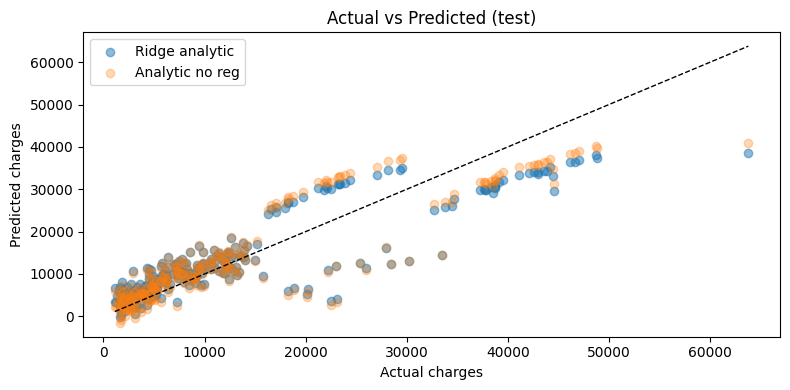


Top coefficients (abs, ridge analytic):
 intercept           13317.933040
smoker               8707.951410
age                  3281.574967
bmi                  1882.051410
children              498.566603
region_southwest      284.170020
region_southeast      162.333957
region_northwest      124.369981
sex                    47.141923
dtype: float64

Full coefficients:
 intercept           13317.933040
age                  3281.574967
sex                    47.141923
bmi                  1882.051410
children              498.566603
smoker               8707.951410
region_northwest     -124.369981
region_southeast     -162.333957
region_southwest     -284.170020
dtype: float64


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

df = pd.read_csv('insurance.csv')

print("Пропуски:\n", df.isnull().sum())
print("\nОписательная статистика:\n", df.describe(include='all'))

cat_cols = ['sex', 'smoker', 'region']
num_cols = [c for c in df.columns if c not in cat_cols + ['charges']]

df_enc = df.copy()
df_enc['sex'] = (df_enc['sex'] == 'male').astype(int)
df_enc['smoker'] = (df_enc['smoker'] == 'yes').astype(int)
df_enc = pd.get_dummies(df_enc, columns=['region'], drop_first=True)

def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series[(series < lower) | (series > upper)]

for c in num_cols + ['charges']:
    outs = detect_outliers_iqr(df_enc[c])
    print(f"{c}: {len(outs)} выбросов (IQR)")

corr = df_enc.corr()
print("\nКорреляционная матрица:\n", corr)
print("\nКорреляция признаков с charges (по убыванию):\n",
      corr['charges'].abs().sort_values(ascending=False))

y = df_enc['charges'].values.reshape(-1, 1)
X = df_enc.drop(columns=['charges']).values
feature_names = list(df_enc.drop(columns=['charges']).columns)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = np.hstack([np.ones((X.shape[0],1)), X])
feature_names = ['intercept'] + feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def analytic_solution(X, y):
    XtX = X.T.dot(X)
    Xty = X.T.dot(y)
    theta = np.linalg.pinv(XtX).dot(Xty)
    return theta

theta_analytic = analytic_solution(X_train, y_train)

def gradient_descent(X, y, lr=1e-3, n_iters=20000, tol=1e-6, verbose=False):
    n, m = X.shape
    theta = np.zeros((m,1))
    prev_loss = np.inf
    for i in range(n_iters):
        preds = X.dot(theta)
        error = preds - y
        loss = (error**2).mean()
        grad = (2.0/n) * X.T.dot(error)
        theta -= lr * grad
        if verbose and (i % (n_iters//5) == 0):
            print(f"iter {i}, loss {loss:.4f}")
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return theta, loss

theta_gd, loss_gd = gradient_descent(X_train, y_train, lr=1e-3, n_iters=200000, tol=1e-8)
print("GD train loss:", loss_gd)

def analytic_ridge(X, y, lam):
    m = X.shape[1]
    I = np.eye(m)
    I[0,0] = 0.0
    theta = np.linalg.pinv(X.T.dot(X) + lam * I).dot(X.T).dot(y)
    return theta

def gradient_descent_ridge(X, y, lam=1.0, lr=1e-3, n_iters=200000, tol=1e-6):
    n, m = X.shape
    theta = np.zeros((m,1))
    prev_loss = np.inf
    for i in range(n_iters):
        preds = X.dot(theta)
        error = preds - y
        loss = (error**2).mean() + lam * (theta[1:]**2).mean()
        grad = (2.0/n) * X.T.dot(error) + 2 * lam * np.vstack([[[0.0]], theta[1:]])/m
        theta -= lr * grad
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return theta, loss

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
lambdas = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
results = []
for lam in lambdas:
    th = analytic_ridge(X_tr, y_tr, lam)
    mse_val = mean_squared_error(y_val, X_val.dot(th))
    results.append((lam, mse_val))
print("Lambda vs val MSE (analytic):", results)

best_lam = min(results, key=lambda x: x[1])[0]
theta_ridge_analytic = analytic_ridge(X_train, y_train, best_lam)
theta_ridge_gd, loss_ridge_gd = gradient_descent_ridge(X_train, y_train, lam=best_lam, lr=1e-3, n_iters=200000)

y_mean = y_train.mean()
mse_const = mean_squared_error(y_test, np.full_like(y_test, y_mean))

y_pred_analytic = X_test.dot(theta_analytic)
mse_analytic = mean_squared_error(y_test, y_pred_analytic)

y_pred_gd = X_test.dot(theta_gd)
mse_gd = mean_squared_error(y_test, y_pred_gd)

y_pred_ridge = X_test.dot(theta_ridge_analytic)
mse_ridge_analytic = mean_squared_error(y_test, y_pred_ridge)

y_pred_ridge_gd = X_test.dot(theta_ridge_gd)
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)

print("\nTest MSEs:")
print(f"Константная (mean) MSE: {mse_const:.2f}")
print(f"Аналитическая (Normal eq) MSE: {mse_analytic:.2f}")
print(f"GD (no reg) MSE: {mse_gd:.2f}")
print(f"Ridge analytic (lambda={best_lam}) MSE: {mse_ridge_analytic:.2f}")
print(f"Ridge GD (lambda={best_lam}) MSE: {mse_ridge_gd:.2f}")

plt.figure(figsize=(8,4))
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label='Ridge analytic')
plt.scatter(y_test, y_pred_analytic, alpha=0.3, label='Analytic no reg')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel('Actual charges')
plt.ylabel('Predicted charges')
plt.legend()
plt.title('Actual vs Predicted (test)')
plt.tight_layout()
plt.show()

coefs = pd.Series(theta_ridge_analytic.flatten(), index=feature_names)
print("\nTop coefficients (abs, ridge analytic):\n", coefs.abs().sort_values(ascending=False).head(10))
print("\nFull coefficients:\n", coefs)
